![image](https://user-images.githubusercontent.com/20357655/145710301-ad00ab66-2378-404f-a918-576aba834ff9.png)

In this homework, we will try to implement a `View Synthesis` model that allows us to generate new scene views based on a single image.

The basic idea is to use `differentiable point cloud rendering`, which is used to convert a hidden 3D feature point cloud into a target view.
The projected features are decoded by `refinement network` to inpaint missing regions and generate a realistic output image.

### Overall pipeline disribed below

![image](https://user-images.githubusercontent.com/20357655/145710444-0d0e163f-6996-4eb8-81c0-69798b11c5a6.png)

# Data
## Download KITTI dataset

In [1]:
# from gfile import download_file_from_google_drive


# download_file_from_google_drive(
#     '1lqspXN10biBShBIVD0yvgnl1nIPPhRdC',
#     'kitti.zip'
# )

In [2]:
# !unzip kitti.zip

In [ ]:
! pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"
! conda install -y av -c conda-forge

## Dataset

In [6]:
%matplotlib inline

from tqdm import tqdm
from itertools import islice
from IPython.display import clear_output, HTML
from collections import defaultdict

from kitti import KITTIDataLoader

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

import torchvision

from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import PerspectiveCameras, compositing, rasterize_points
from matplotlib import pyplot as plt

In [7]:
def split_RT(RT):
    return RT[..., :3, :3], RT[..., :3, 3]

def renormalize_image(image):
    return image * 0.5 + 0.5

In [8]:
dataset = KITTIDataLoader('/kaggle/input/kitti-3dsynth/dataset_kitti')

Each instance of dataset contain `source` and `target` images, `extrinsic` and `intrinsic` camera parameters for `source` and `targer` images.

It is highly recommended to understand these concepts, e.g., here https://ksimek.github.io/2012/08/22/extrinsic/

In [9]:
images, cameras = dataset[0].values()

(-0.5, 255.5, 255.5, -0.5)

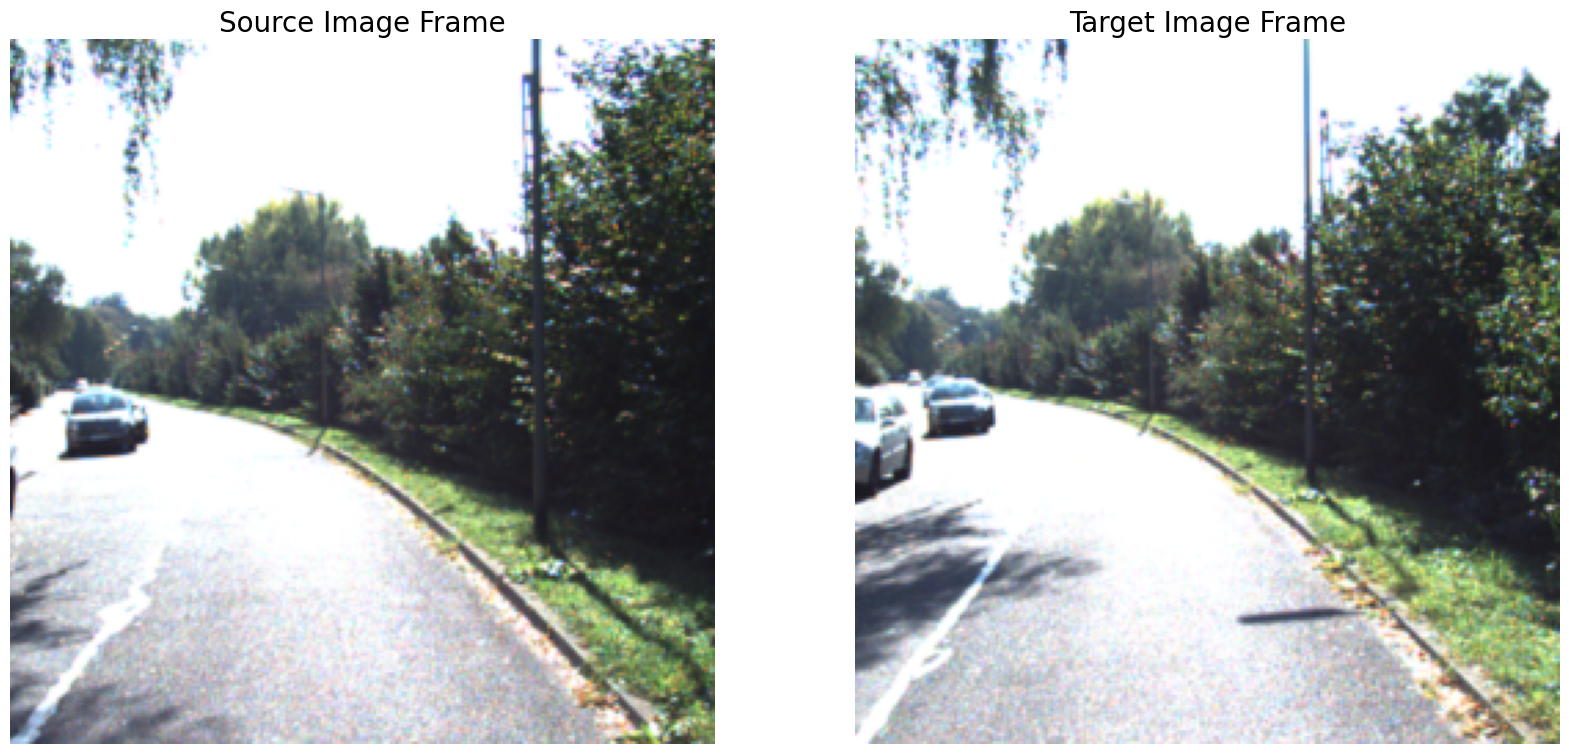

In [10]:
plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
ax.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)
ax.set_title('Source Image Frame', fontsize=20)
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(images[1].permute(1, 2, 0) * 0.5 + 0.5)
ax.set_title('Target Image Frame', fontsize=20)
ax.axis('off')

In [11]:
source_camera = PerspectiveCameras(
    R=split_RT(cameras[0]['P'])[0][None],
    T=split_RT(cameras[0]['P'])[1][None],
    K=torch.from_numpy(cameras[0]['K'])[None]
)

target_camera = PerspectiveCameras(
    R=split_RT(cameras[1]['P'])[0][None],
    T=split_RT(cameras[1]['P'])[1][None],
    K=torch.from_numpy(cameras[1]['K'])[None]
)

plot_scene(
    {
        'scene': {
            'source_camera': source_camera,
            'target_camera': target_camera
        }
    },
)

In [12]:
indexes = torch.randperm(len(dataset))

train_indexes = indexes[:-1000]
validation_indexes = indexes[-1000:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

train_dataloader = DataLoader(
    train_dataset, batch_size=14, num_workers=4,
    shuffle=True, drop_last=True, pin_memory=True
)
validation_dataloder = DataLoader(
    validation_dataset, batch_size=14, num_workers=4,
    pin_memory=True
)

---

# Models

So, we need to implement `Spatial Feature Predictor`, `Depth Regressor`, `Point Cloud Renderer` and `RefinementNetwork`.

One of the main building blocks in these networks is `ResNetBlock`, but with some modifications:

![image](https://user-images.githubusercontent.com/20357655/145711537-eebb0cb9-8935-4d65-bc4b-559c1e19ba98.png)

So, let's implement it, but without the noise part `Linear + z` (let's omit it, since we do not use the adversarial criterion)

In [13]:
class ResNetBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        mode = 'identity'
    ):
        super().__init__()
        
        # TODO
        self.mode = {
            'identity': nn.Identity(),
            'upsample': nn.Upsample(scale_factor=2)
        }.get(mode, nn.AvgPool2d(kernel_size=2))

        self.skip = nn.Sequential(self.mode, nn.Conv2d(in_channels, out_channels, 1))
        self.backbone = nn.Sequential(
            nn.BatchNorm2d(in_channels), nn.ReLU(), 
            self.mode, nn.Conv2d(in_channels, out_channels, 3, 1, 1), 
            nn.BatchNorm2d(out_channels), nn.ReLU(), 
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

    
    def forward(self, input):
        # TODO
        return self.skip(input) + self.backbone(input)

## Spatial Feature Predictor

![image](https://user-images.githubusercontent.com/20357655/145711931-be08e4f9-f383-4942-8b93-f8bdfd3060d2.png)

In [14]:
class SpatialFeatureNetwork(nn.Module):
    
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        # TODO
        layers = [
            ResNetBlock(3, 16), ResNetBlock(16, 16), ResNetBlock(16, 16), ResNetBlock(16, 32),
            ResNetBlock(32, 32), ResNetBlock(32, 32), ResNetBlock(32, 32), ResNetBlock(32, 64)
        ]
        self.blocks = nn.Sequential(*layers)

    def forward(self, input: torch.Tensor):
        return self.blocks(input)

sf_net = SpatialFeatureNetwork()

## Depth Regressor

![image](https://user-images.githubusercontent.com/20357655/145711785-690008e5-96d0-418f-adf1-1509e399c92e.png)

An `Enc Block` consists of a sequence of Leaky ReLU, convolution (stride 2, padding 1, kernel size 4), and batch normalisation layers.

A `Dec Block` consists of a sequence of ReLU, 2x bilinear upsampling, convolution (stride 1, padding 1, kernel size3), and batch normalisation layers (except for the final layer, which has no batch normalisation layer).

In [15]:
class Unet(nn.Module):

    def __init__(
        self,
        num_filters=32,
        channels_in=3,
        channels_out=3
    ):
        super(Unet, self).__init__()
        # TODO
        self.conv = nn.Conv2d(channels_in, num_filters, 3, 2, 1)
        self.enc_blocks = nn.ModuleList([
            self._enc_block(num_filters, 64),
            self._enc_block(64, 128),
            self._enc_block(128, 256),
            self._enc_block(256, 256),
            self._enc_block(256, 256),
            self._enc_block(256, 256),
            self._enc_block(256, 256)
        ])
        self.dec_blocks = nn.ModuleList([
            self._dec_block(256, 256),
            self._dec_block(512, 256),
            self._dec_block(512, 256),
            self._dec_block(512, 256),
            self._dec_block(512, 128),
            self._dec_block(256, 64),
            self._dec_block(128, 32),
            self._dec_block(64, channels_out, batch_norm=False)
        ])

    def _enc_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels)
        )

    def _dec_block(self, in_channels, out_channels, batch_norm=True):
        layers = [
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

    def forward(self, input):
        # TODO
        x = self.conv(input)
        enc_outputs = [x]
        for enc in self.enc_blocks:
            x = enc(x)
            enc_outputs.append(x)

        for i, dec in enumerate(self.dec_blocks):
            if i == 0:
                x = dec(x)
            else:
                x = dec(torch.cat([x, enc_outputs[-(i+1)]], 1))
        return torch.sigmoid(x)


## Refinement Network

![image](https://user-images.githubusercontent.com/20357655/145711921-45ebf1e5-e852-4c47-8b93-d545f67dc6bf.png)

In [16]:
class RefinementNetwork(nn.Module):
    
    def __init__(self, in_channels=64, out_channels=3):
        super().__init__()
        # TODO
        resnet_blocks = [
            (in_channels, 32, 'identity'),
            (32, 128, 'avg'),
            (128, 64, 'avg'),
            (64, 64, 'identity'),
            (64, 64, 'upsample'),
            (64, 64, 'upsample'),
            (64, 64, 'identity'),
            (64, out_channels, 'identity')
        ]
        
        self.blocks = nn.Sequential(*[ResNetBlock(in_ch, out_ch, mode=mode) for in_ch, out_ch, mode in resnet_blocks])

    
    def forward(self, input: torch.Tensor):
        return self.blocks(input)

## Auxiliary network

In [17]:
class VGG19(nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = torchvision.models.vgg19(
            pretrained=True
        ).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2, 7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7, 12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        # Normalize the image so that it is in the appropriate range
        h_relu1 = self.slice1(X)
        h_relu2 = self.slice2(h_relu1)
        h_relu3 = self.slice3(h_relu2)
        h_relu4 = self.slice4(h_relu3)
        h_relu5 = self.slice5(h_relu4)
        out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
        return out

---

# Criterions & Metrics

In [18]:
class PerceptualLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Set to false so that this part of the network is frozen
        self.model = VGG19(requires_grad=False)
        self.criterion = nn.L1Loss()
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]

    def forward(self, pred_img, gt_img):
        gt_fs = self.model(gt_img)
        pred_fs = self.model(pred_img)

        # Collect the losses at multiple layers (need unsqueeze in
        # order to concatenate these together)
        loss = 0
        for i in range(0, len(gt_fs)):
            loss += self.weights[i] * self.criterion(pred_fs[i], gt_fs[i])

        return loss


In [19]:
def psnr(predicted_image, target_image):
    batch_size = predicted_image.size(0)
    mse_err = (
        (predicted_image - target_image)
        .pow(2).sum(dim=1)
        .view(batch_size, -1).mean(dim=1)
    )

    psnr = 10 * (1 / mse_err).log10()
    return psnr.mean()

---

# Point Cloud Renderer

`Differential Rasterization` is a key component of our system. We will use the algorithm already implemented in `pytorch3d`.

![image](https://user-images.githubusercontent.com/20357655/145715968-94abbe1a-8d14-4c20-98c4-61afd9161ada.png)

For more details read (3.2) https://arxiv.org/pdf/1912.08804.pdf

In [20]:
class PointsRasterizerWithBlending(nn.Module):
    """
    Rasterizes a set of points using a differentiable renderer. 
    """

    def __init__(self, radius=1.5, image_size=256, points_per_pixel=8):
        super().__init__()

        self.radius = radius
        self.image_size = image_size
        self.points_per_pixel = points_per_pixel
        
        self.rad_pow = 2
        self.tau = 1.0

    def forward(self, point_cloud, spatial_features):
        batch_size = spatial_features.size(0)

        # Make sure these have been arranged in the same way
        assert point_cloud.size(2) == 3
        assert point_cloud.size(1) == spatial_features.size(2)

        point_cloud[:, :, 1] = -point_cloud[:, :, 1]
        point_cloud[:, :, 0] = -point_cloud[:, :, 0]

        radius = float(self.radius) / float(self.image_size) * 2.0

        point_cloud = Pointclouds(points=point_cloud, features=spatial_features.permute(0, 2, 1))
        points_idx, _, dist = rasterize_points(
            point_cloud, self.image_size, radius, self.points_per_pixel
        )

        dist = dist / pow(radius, self.rad_pow)

        alphas = (
            (1 - dist.clamp(max=1, min=1e-3).pow(0.5))
            .pow(self.tau)
            .permute(0, 3, 1, 2)
        )
    
        transformed_src_alphas = compositing.alpha_composite(
            points_idx.permute(0, 3, 1, 2).long(),
            alphas,
            point_cloud.features_packed().permute(1, 0),
        )

        return transformed_src_alphas

And `PointsManipulator` do the following steps:

    1) Create virtual image place in [normalized coordinate](https://pytorch3d.org/docs/cameras)
    2) Move camera according to `regressed depth`
    3) Rotate points according to target camera paramers
    4) And finally render them with help of `PointsRasterizerWithBlending`

In [21]:
class PointsManipulator(nn.Module):
    EPS = 1e-5

    def __init__(self, image_size):
        super().__init__()
        # Assume that image plane is square

        self.splatter = PointsRasterizerWithBlending(
            radius=1.0,
            image_size=image_size,
            points_per_pixel=128,
        )

        xs = torch.linspace(0, image_size - 1, image_size) / \
            float(image_size - 1) * 2 - 1
        ys = torch.linspace(0, image_size - 1, image_size) / \
            float(image_size - 1) * 2 - 1

        xs = xs.view(1, 1, 1, image_size).repeat(1, 1, image_size, 1)
        ys = ys.view(1, 1, image_size, 1).repeat(1, 1, 1, image_size)

        xyzs = torch.cat(
            (xs, -ys, -torch.ones(xs.size()), torch.ones(xs.size())), 1
        ).view(1, 4, -1)

        self.register_buffer("xyzs", xyzs)

    def project_pts(self, depth, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2):
        # Project the world points into the new view
        projected_coors = self.xyzs * depth
        projected_coors[:, -1, :] = 1

        # Transform into camera coordinate of the first view
        cam1_X = K_inv.bmm(projected_coors)

        # Transform into world coordinates
        RT = RT_cam2.bmm(RTinv_cam1)

        wrld_X = RT.bmm(cam1_X)

        # And intrinsics
        xy_proj = K.bmm(wrld_X)

        # And finally we project to get the final result
        mask = (xy_proj[:, 2:3, :].abs() < self.EPS).detach()

        # Remove invalid zs that cause nans
        zs = xy_proj[:, 2:3, :]
        zs[mask] = self.EPS

        sampler = torch.cat((xy_proj[:, 0:2, :] / -zs, xy_proj[:, 2:3, :]), 1)
        sampler[mask.repeat(1, 3, 1)] = -10
        # Flip the ys
        sampler = sampler * torch.Tensor([1, -1, -1]).unsqueeze(0).unsqueeze(
            2
        ).to(sampler.device)

        return sampler

    def forward_justpts(
        self,
        spatial_features, depth,
        K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2
    ):
        # Now project these points into a new view
        batch_size, c, w, h = spatial_features.size()

        if len(depth.size()) > 3:
            # reshape into the right positioning
            depth = depth.view(batch_size, 1, -1)
            spatial_features = spatial_features.view(batch_size, c, -1)

        pointcloud = self.project_pts(
            depth, K, K_inv, RT_cam1, RTinv_cam1, RT_cam2, RTinv_cam2
        )
        pointcloud = pointcloud.permute(0, 2, 1).contiguous()
        result = self.splatter(pointcloud, spatial_features)

        return result

---

# All together

In [22]:
class ViewSynthesisModel(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.spatial_feature_predictor = SpatialFeatureNetwork()
        self.depth_regressor = Unet(channels_in=3, channels_out=1)
        self.point_cloud_renderer = PointsManipulator(image_size=256)
        self.refinement_network = RefinementNetwork()

        # Special constant for KITTI dataset
        self.z_min = 1.0
        self.z_max = 50.0

    def _predict_spatial_feature(self, source_image):
        return self.spatial_feature_predictor(source_image)

    def _predict_depth(self, source_image):
        depth = self.depth_regressor(source_image)
        return depth * (self.z_max - self.z_min) + self.z_min

    def _generate_new_features(self, spatial_feature, depth, K, Kinv, P1, Pinv1, P2, Pinv2):
        return self.point_cloud_renderer.forward_justpts(spatial_feature, depth, K, Kinv, P1, Pinv1, P2, Pinv2)

    def _refine_image(self, new_features):
        return self.refinement_network(new_features)

    def forward(self, source_image, Pinv1, P1, Pinv2, P2, K, Kinv):
        # TODO
        # 1) Predict spatial feature for source image
        # 2) Predict depth for source image (dont forget to renormalize depth with z_min/z_max)
        # 3) Generate new features with `point_cloud_renderer`
        # 4) And finnaly apply `refinement_network` to obtain new image
        # 5) return new image, and depth of source image


        spatial_feature = self._predict_spatial_feature(source_image)
        depth = self._predict_depth(source_image)
        new_features = self._generate_new_features(spatial_feature, depth, K, Kinv, P1, Pinv1, P2, Pinv2)
        new_image = self._refine_image(new_features)

        return new_image, depth

---

# Training

In order for the work to be accepted, you must achieve a quality of ~0.5 (validation loss value) and visualize several samples as in the example

In [23]:
device = torch.device('cuda:0')

model = ViewSynthesisModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
histoty = defaultdict(list)

l1_criterion = nn.L1Loss()
perceptual_criterion = PerceptualLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 160MB/s]


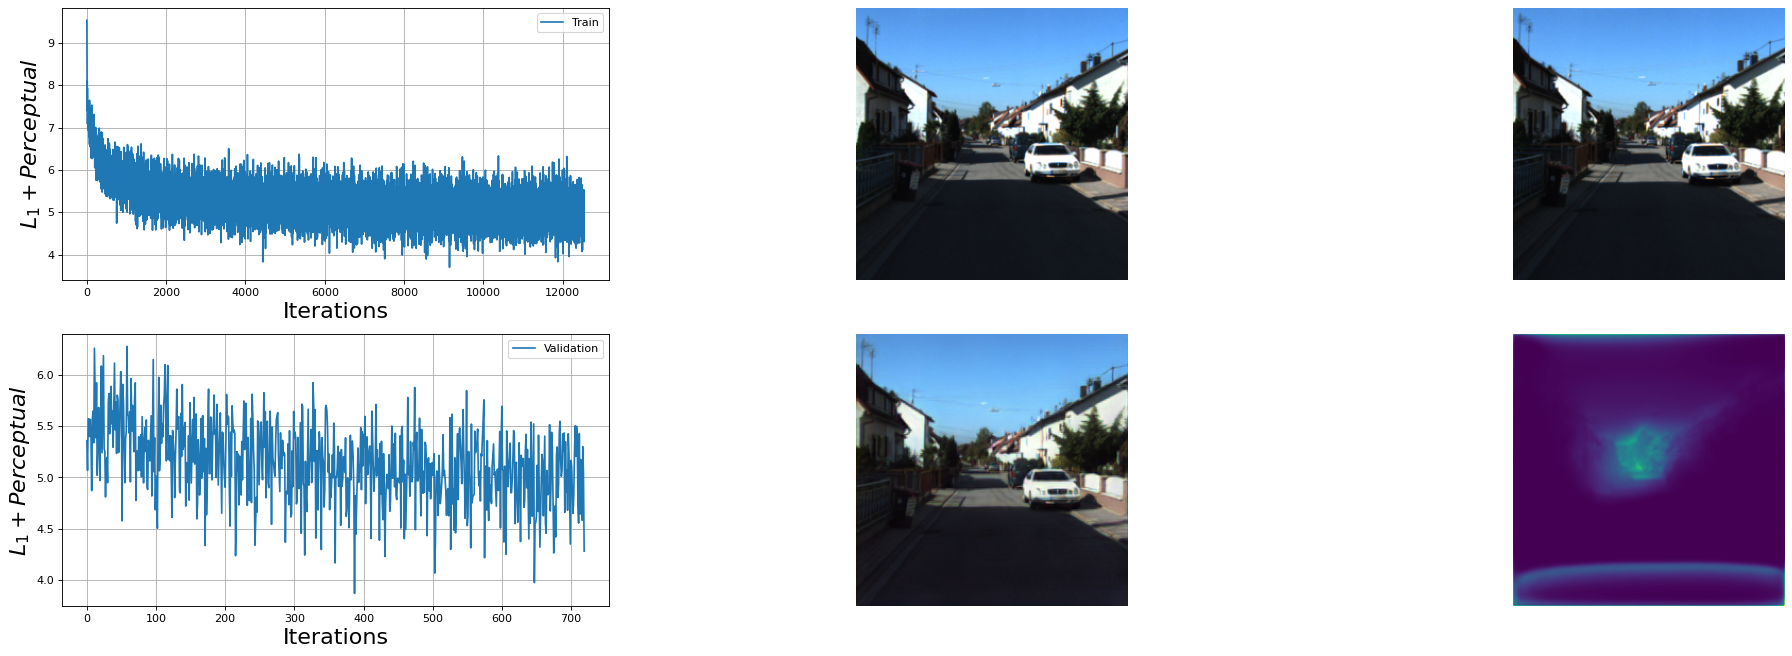

In [24]:
for epoch in range(10):
    for i, batch in tqdm(enumerate(train_dataloader, 2), total=len(train_dataloader)):
        source_image = batch["images"][0].to(device)
        target_image = batch["images"][-1].to(device)
        
        # TODO
        def get_camera_params(batch, device):
            K = batch["cameras"][0]['K'].to(device)
            Kinv = batch["cameras"][0]['Kinv'].to(device)
            Pinv1 = batch["cameras"][0]['Pinv'].to(device)
            P1 = batch["cameras"][0]['P'].to(device)
            Pinv2 = batch["cameras"][1]['Pinv'].to(device)
            P2 = batch["cameras"][1]['P'].to(device)
            return K, Kinv, Pinv1, P1, Pinv2, P2

        K, Kinv, Pinv1, P1, Pinv2, P2 = get_camera_params(batch, device)
        generated_image, regressed_depth = model(source_image, Pinv1, P1, Pinv2, P2, K, Kinv)

        def compute_loss(generated_image, target_image, l1_criterion, perceptual_criterion):
            return l1_criterion(generated_image, target_image) \
                + 10 * perceptual_criterion(
                renormalize_image(generated_image),
                renormalize_image(target_image)
            )

        loss = compute_loss(generated_image, target_image, l1_criterion, perceptual_criterion)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        histoty['train_loss'].append(loss.item())
    
    for i, batch in tqdm(enumerate(validation_dataloder), total=len(validation_dataloder)):
        source_image = batch["images"][0].to(device)
        target_image = batch["images"][-1].to(device)
        
        with torch.no_grad():
            # TODO
            K, Kinv, Pinv1, P1, Pinv2, P2 = get_camera_params(batch, device)
            generated_image, regressed_depth = model(source_image, Pinv1, P1, Pinv2, P2, K, Kinv)
        loss = l1_criterion(generated_image, target_image) \
            + 10 * perceptual_criterion(
            renormalize_image(generated_image),
            renormalize_image(target_image)
        )

        histoty['validation_loss'].append(loss.item())
    
        
    clear_output()
    fig = plt.figure(figsize=(30, 15), dpi=80)
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(histoty['train_loss'], label='Train')
    ax1.set_xlabel('Iterations', fontsize=20)
    ax1.set_ylabel(r'${L_1} + Perceptual$', fontsize=20)
    ax1.legend()
    ax1.grid()
    
    ax2 = plt.subplot(3, 3, 4)
    ax2.plot(histoty['validation_loss'], label='Validation')
    ax2.set_xlabel('Iterations', fontsize=20)
    ax2.set_ylabel(r'${L_1} + Perceptual$', fontsize=20)
    ax2.legend()
    ax2.grid()

    for index, image in zip(
        (2, 3, 5, 6),
        (source_image, target_image, generated_image, regressed_depth)
    ):
        ax = plt.subplot(3, 3, index)
        im = ax.imshow(renormalize_image(image.detach().cpu()[0]).permute(1, 2, 0))
        ax.axis('off')

    plt.show()

In [25]:
import pickle
with open("/kaggle/working/model.pkl", "wb") as fout:
    pickle.dump(model, fout)

# Visualize

Goes along depth and generate new views

In [26]:
RTs = []
for i in torch.linspace(0, 0.5, 40):
    current_RT = torch.eye(4).unsqueeze(0)
    current_RT[:, 2, 3] = i
    RTs.append(current_RT.to(device))
identity_matrx = torch.eye(4).unsqueeze(0).to(device)

In [27]:
random_instance_index = 245
model.eval()

with torch.no_grad():
    images, cameras = validation_dataset[random_instance_index].values()
    # Input values
    input_img = images[0][None].cuda()

    # Camera parameters
    K = torch.from_numpy(cameras[0]["K"])[None].to(device)
    K_inv = torch.from_numpy(cameras[0]["Kinv"])[None].to(device)
    
    spatial_features = model.spatial_feature_predictor(input_img)
    regressed_depth = model.depth_regressor(input_img) * (model.z_max - model.z_min) + model.z_min

    new_images = []
    for current_RT in RTs:
        generated_features = model.point_cloud_renderer.forward_justpts(
            spatial_features,
            regressed_depth,
            K,
            K_inv,
            identity_matrx,
            identity_matrx,
            current_RT,
            None
        )
        generated_image = model.refinement_network(generated_features)
        new_images.append(renormalize_image(generated_image.cpu()).clamp(0, 1).mul(255).to(torch.uint8))

In [28]:
frames = torch.cat(new_images).permute(0, 2, 3, 1)
torchvision.io.write_video('video.mp4', frames, fps=20)

In [29]:
HTML("""
    <video width="256" alt="test" controls>
        <source src="video.mp4" type="video/mp4">
    </video>
""")

# Quality benchmark

![gif](benchmark_video_v1.gif)
![gif](benchmark_video_v2.gif)
![gif](benchmark_video_v3.gif)